# Notebook configuration

In [275]:
run_numbers   = 4575, 4576
save_plots    = False
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "run4446_corrections_5.4mm.h5"
inputfilename = "/Users/Gonzalo/github/NEXTdata/Bkg/dst_{}.root.h5"

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Prange        =  -3.2, 3.2  
Erange_raw    =     0, 65e4
Erange_zcorr  =     0, 65e4
Erange_xycorr =     0, 65e4
Erange_fit    =     0, 65e4
Qrange        =     0, 10e3
QErange       =     0, Qrange[1]/Erange_xycorr[1]
Frange        =   0.8, 1.5
Urange        =  1e-3, 1.2e-2

S1Erange      =     0, 1000
S1Wrange      =     0, 600
S1Hrange      =     0, 200
S2Wrange      =     0, 200
S2Hrange      =     0, 30e3
NSirange      =     0, 200

XRrange_raw   =     0, 14e3
XRrange_corr  =   6e3, 12e3

Zrange_LT     =    50, 520
Zrange_XY     =     0, 520
nX, nY, nR    =    50,  50, 50
x0, y0, r0    =    40, -40, 15 # for lifetime scan


In [276]:
def poisson_sigma(x, default=3):
    u = x**0.5
    u[x==0] = default
    return u

# Kr analysis

In [277]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .kdst_io        as kdstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import save_to_folder

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Mon Aug  7 12:31:24 2017


#### General plotting options

In [278]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [279]:
full_0 = dstf.load_dst(inputfilename.format(run_numbers[0]), "DST", "Events")
full_0 = full_0[full_0.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full_0))
full_0.head()

103188


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.501694e+09,0,1,175.0,16.950249,83.480485,966475.0,22.953125,12851.089844,...,1004212.5,83,37.7375,37.7375,179.713210,0.742255,179.714743,0.004130,18.039865,16.189089
1,2,1.501694e+09,0,1,200.0,16.184626,84.606597,982150.0,16.929188,17176.833984,...,1003462.5,130,21.3125,21.3125,-114.017637,-119.770451,165.363184,-2.331592,23.260931,24.588756
2,3,1.501694e+09,0,1,300.0,55.191978,337.793447,862925.0,73.228875,12384.879883,...,1060987.5,334,198.0625,198.0625,103.628712,80.119765,130.988880,0.658149,35.954385,38.160059
3,4,1.501694e+09,0,1,300.0,54.743404,317.881576,680225.0,73.067875,8295.044922,...,1009887.5,168,329.6625,329.6625,-138.282167,-24.427579,140.423161,-2.966746,24.857161,24.915554
4,5,1.501694e+09,0,1,275.0,33.143425,186.596640,867000.0,57.418250,9467.808594,...,1004137.5,134,137.1375,137.1375,162.106696,-26.594893,164.273763,-0.162609,21.769800,21.138556


In [280]:
full_1 = dstf.load_dst(inputfilename.format(run_numbers[1]), "DST", "Events")
full_1 = full_1[full_1.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full_1))
full_1.head()

16989


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.501779e+09,0,1,350.0,120.423058,704.936500,502150.0,85.786875,7625.978027,...,1026887.5,201,524.7375,524.7375,-80.773034,-70.557427,107.250331,-2.423598,24.900073,69.133931
1,3,1.501779e+09,0,2,275.0,40.564922,231.311592,836375.0,35.106250,8960.984375,...,1019787.5,99,183.4125,183.4125,102.121633,151.343037,182.574759,0.977205,19.378291,17.866026
2,3,1.501779e+09,1,2,275.0,40.564922,231.311592,836375.0,11.952500,4894.137207,...,1242512.5,25,406.1375,406.1375,12.187365,93.028287,93.823207,1.440531,10.413879,11.545618
3,4,1.501779e+09,0,1,275.0,34.079361,180.108108,716050.0,37.733750,7208.128906,...,1006837.5,64,290.7875,290.7875,-153.888344,92.401644,179.498429,2.600845,16.146826,14.203799
4,5,1.501779e+09,0,1,225.0,26.454981,147.920224,907725.0,27.096250,17808.773438,...,1020712.5,98,112.9875,112.9875,2.633786,180.147746,180.166998,1.556177,17.557896,16.573585


In [281]:
XYcorr = dstf.load_xy_corrections(corr_filename)

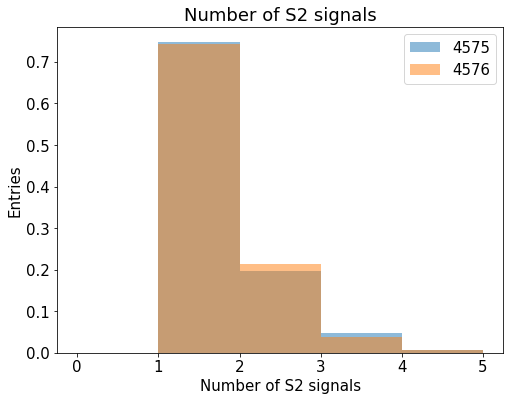

In [282]:
hist(full_0.nS2, 5, (0, 5), label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.nS2, 5, (0, 5), label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

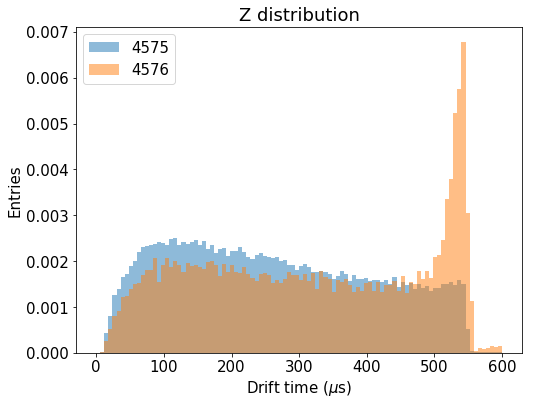

In [283]:
hist(full_0.Z, 100, Zrange, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.Z, 100, Zrange, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

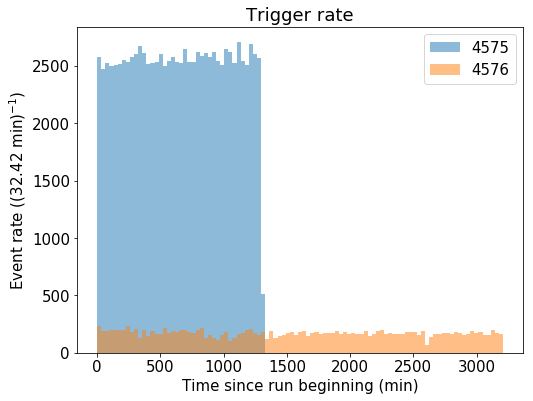

In [284]:
T_0   = full_0.time.values / 60
T_0  -= np.min(T_0)
T_1   = full_1.time.values / 60
T_1  -= np.min(T_1)

Tbins = np.linspace(0, max(T_0.max(), T_1.max()), 100)
 
hist(T_0, Tbins, label=str(run_numbers[0]), alpha=0.5)
hist(T_1, Tbins, label=str(run_numbers[1]), alpha=0.5, new_figure=False)
plt.legend()

labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(Tbins)[0]),
       "Trigger rate")
save("EventRate")

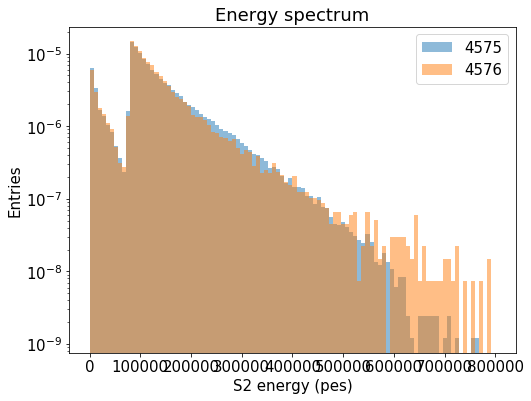

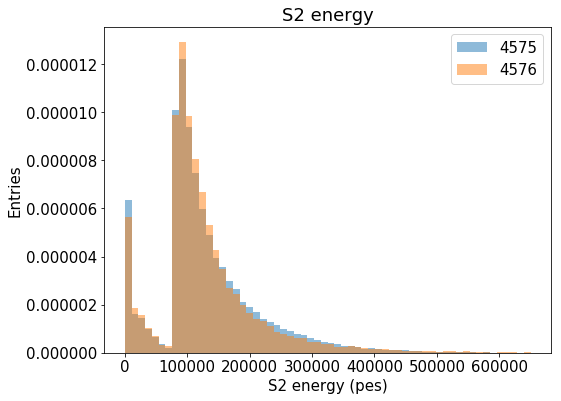

In [285]:
hist(full_0.S2e, 100, (0, 8e5), label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S2e, 100, (0, 8e5), label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
plt.yscale("log")
labels("S2 energy (pes)", "Entries", "Energy spectrum")
save("Raw_energy_wide")

hist(full_0.S2e, 60, Erange_raw, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S2e, 60, Erange_raw, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

# S1 energy

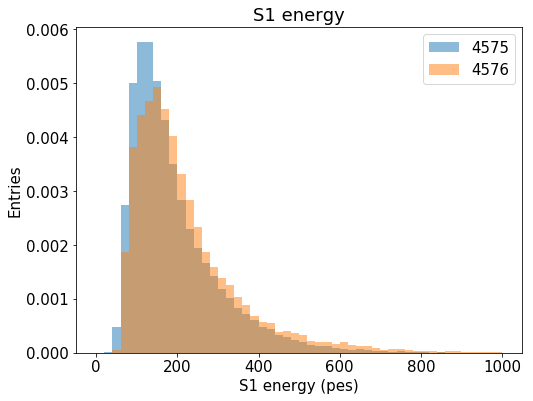

In [286]:
hist(full_0.S1e, 50, S1Erange, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S1e, 50, S1Erange, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

# S1 width

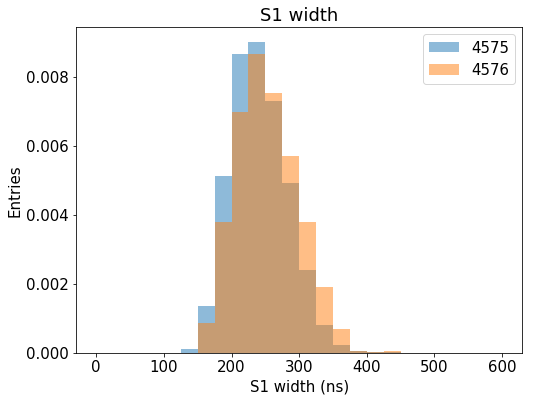

In [287]:
nb = max(S1Wrange)//25
hist(full_0.S1w, nb, S1Wrange, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S1w, nb, S1Wrange, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S1 width (ns)", "Entries", "S1 width")
save("S1width")

# S1 height

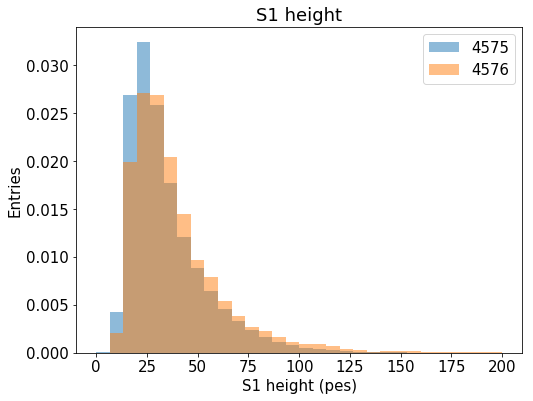

In [288]:
hist(full_0.S1h, 30, S1Hrange, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S1h, 30, S1Hrange, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

# S1 peak to area ratio

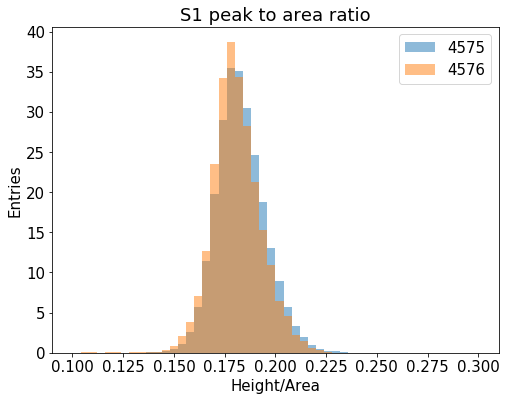

In [289]:
_range = 0.1, 0.3

hist(full_0.S1h/full_0.S1e, 50, _range, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S1h/full_1.S1e, 50, _range, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

# S2 energy

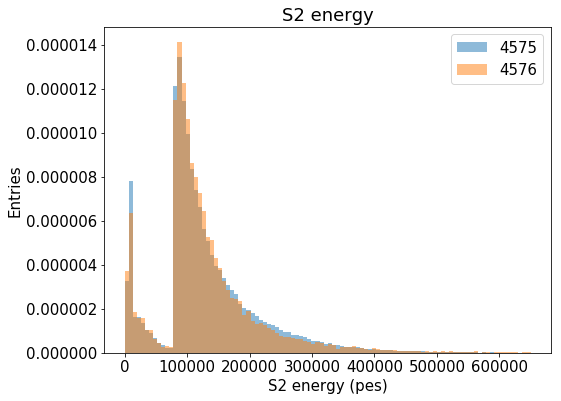

In [290]:
hist(full_0.S2e, 100, Erange_raw, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S2e, 100, Erange_raw, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

# S2 width

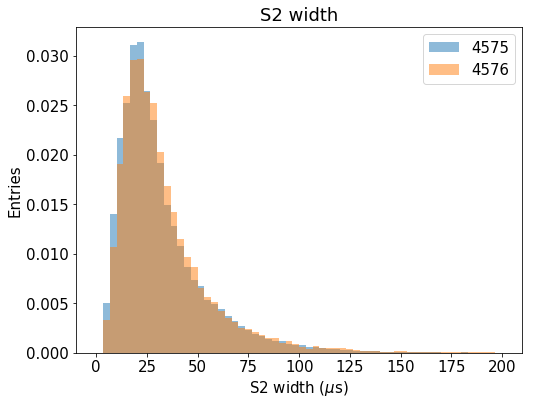

In [291]:
hist(full_0.S2w, 60, S2Wrange, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S2w, 60, S2Wrange, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

# S2 height

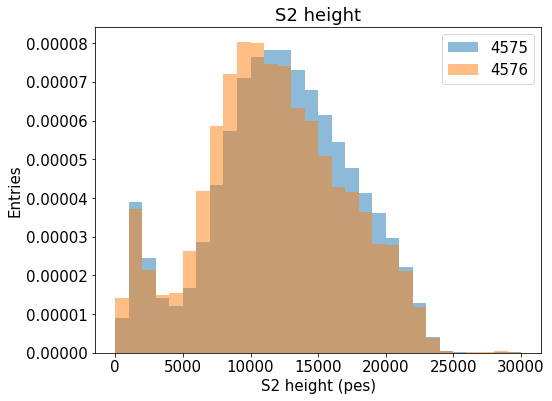

In [292]:
hist(full_0.S2h, 30, S2Hrange, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S2h, 30, S2Hrange, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

# S2 peak to area ratio

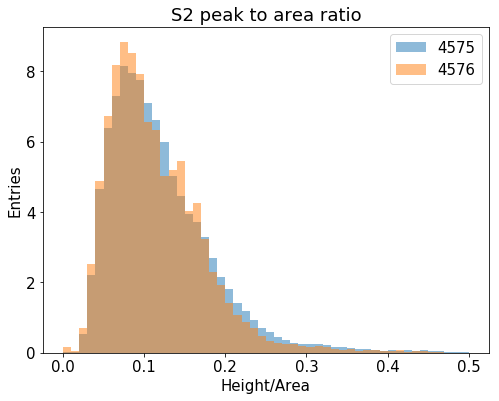

In [293]:
_range = 0, 0.5

hist(full_0.S2h/full_0.S2e, 50, _range, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S2h/full_1.S2e, 50, _range, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

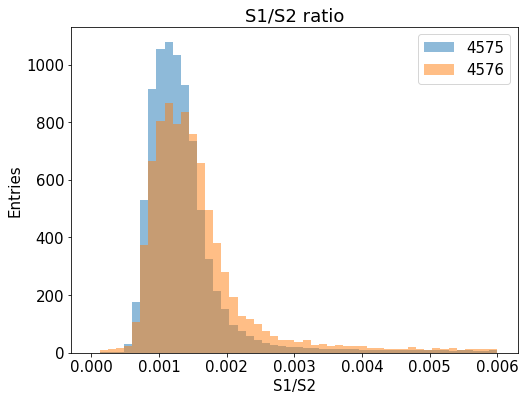

In [294]:
_range = 0, 0.006

hist(full_0.S1e/full_0.S2e, 50, _range, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(full_1.S1e/full_1.S2e, 50, _range, label=str(run_numbers[1]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

# Lifetime calculation

# S2 energy fiducialized

Ratio: 0.32546420126371284
Energy at z=0 = 9259.8 +- 38.9
Lifetime      = 1521.3 +- 36.2
Chi2          = 1.03          
Ratio: 0.2761198422508682
Energy at z=0 = 9238.3 +- 122.0
Lifetime      = 1304.3 +- 72.8
Chi2          = 7.52          


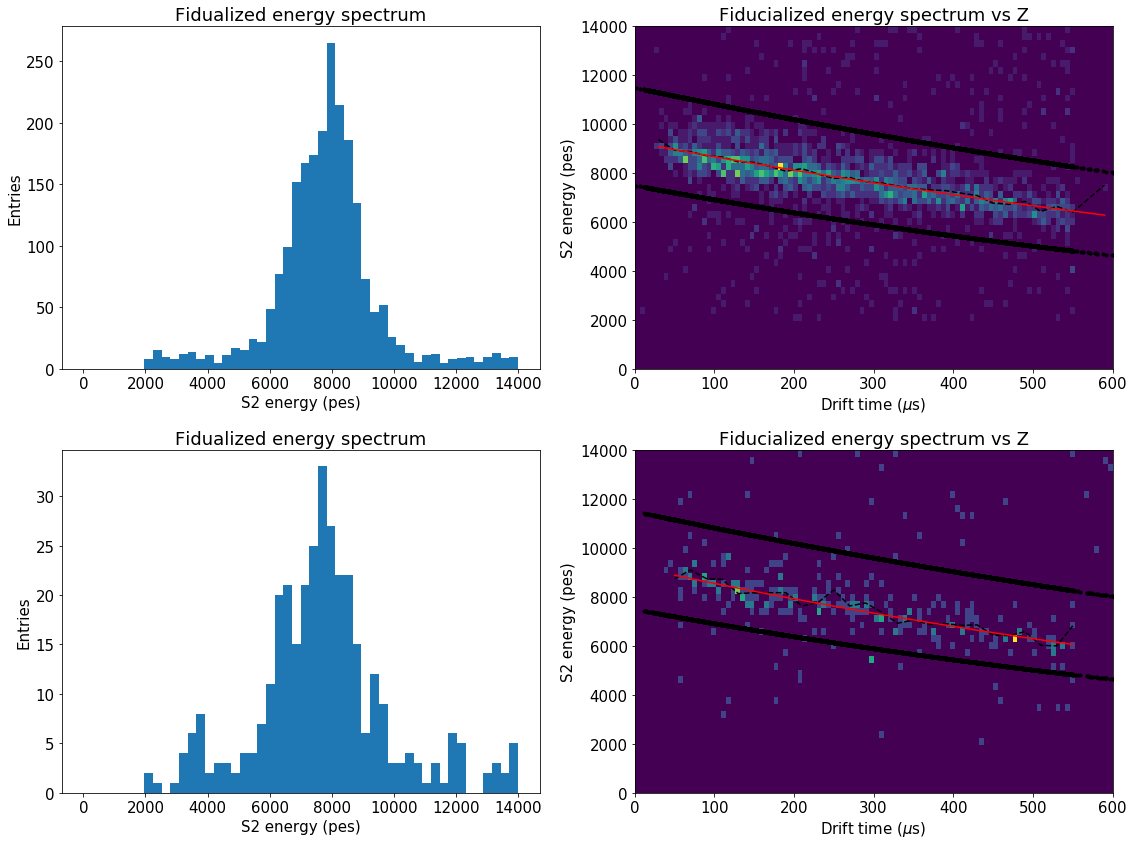

In [295]:
Zcorr = [0, 0]
plt.figure(figsize=(16,12))
for i, fid0 in enumerate([full_0, full_1]):
    fid = fid0[fid0.R < 100] # Fiducialize in order to reduce geometrical effects
    print("Ratio:", len(fid)/len(fid0))

    plt.subplot(2, 2, 2*i+1)
    hist(fid.S2e, 50, range=XRrange_raw, new_figure=False)
    labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
    save("Raw_energy_fiducial")

    low_cut   =  7500 * np.exp(-0.0008*fid.Z.values)
    high_cut  = 11500 * np.exp(-0.0006*fid.Z.values)
    sel       = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background

    plt.subplot(2, 2, 2*i+2)
    hist2d(fid.Z, fid.S2e, (100, 50), range=(Zrange, XRrange_raw), new_figure=False)
    x, y, u_y = fitf.profileX(fid.Z[sel], fid.S2e[sel], 30, xrange=Zrange, yrange=XRrange_raw)

    plt.plot(x, y, profOpt)
    plt.plot(fid.Z.values,  low_cut, "k.")
    plt.plot(fid.Z.values, high_cut, "k.")

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    sel  = u_y>0
    f    = fitf.fit(fitf.expo, x[sel], y[sel], seed, fit_range=Zrange_LT, sigma=u_y[sel])

    plt.plot(x, f.fn(x), fitOpt)
    print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    print("Chi2          = {:.2f}          ".format(f.chi2))

    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
    save("Raw_energy_vsZ_fiducial")

    Zcorr[i] = corrf.LifetimeCorrection(-f.values[1], f.errors[1])
plt.tight_layout()
Zcorr_0, Zcorr_1 = Zcorr

# Correction by attachment and position

In [296]:
E_xyzcorr_0 = full_0.S2e.values * Zcorr_0(full_0.Z.values).value * XYcorr(full_0.X.values, full_0.Y.values).value
E_xyzcorr_1 = full_1.S2e.values * Zcorr_1(full_1.Z.values).value * XYcorr(full_1.X.values, full_1.Y.values).value

In [310]:
____ = np.linspace(100, 600, 101)
for _, __ in zip(____[::2], ____[1::2]):
    print(_, _*511/161, __, __*511/161)

100.0 317.391304348 105.0 333.260869565
110.0 349.130434783 115.0 365.0
120.0 380.869565217 125.0 396.739130435
130.0 412.608695652 135.0 428.47826087
140.0 444.347826087 145.0 460.217391304
150.0 476.086956522 155.0 491.956521739
160.0 507.826086957 165.0 523.695652174
170.0 539.565217391 175.0 555.434782609
180.0 571.304347826 185.0 587.173913043
190.0 603.043478261 195.0 618.913043478
200.0 634.782608696 205.0 650.652173913
210.0 666.52173913 215.0 682.391304348
220.0 698.260869565 225.0 714.130434783
230.0 730.0 235.0 745.869565217
240.0 761.739130435 245.0 777.608695652
250.0 793.47826087 255.0 809.347826087
260.0 825.217391304 265.0 841.086956522
270.0 856.956521739 275.0 872.826086957
280.0 888.695652174 285.0 904.565217391
290.0 920.434782609 295.0 936.304347826
300.0 952.173913043 305.0 968.043478261
310.0 983.913043478 315.0 999.782608696
320.0 1015.65217391 325.0 1031.52173913
330.0 1047.39130435 335.0 1063.26086957
340.0 1079.13043478 345.0 1095.0
350.0 1110.86956522 355.0 

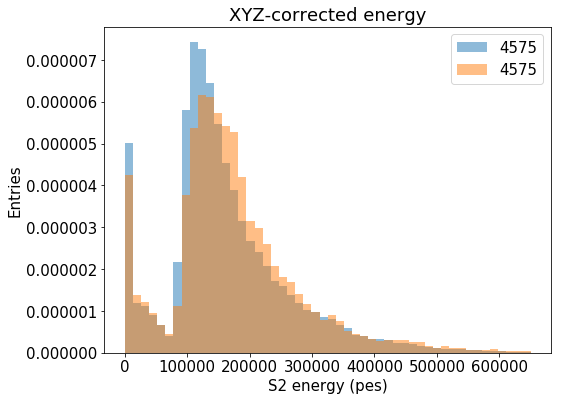

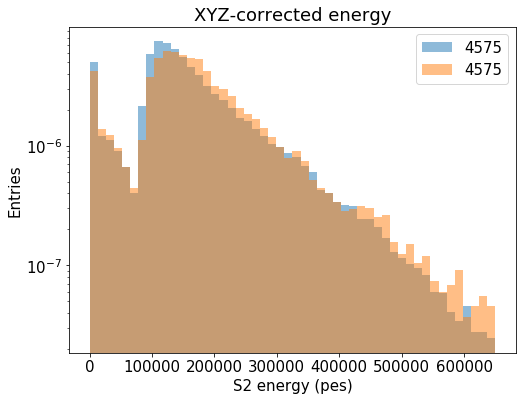

In [303]:
hist(E_xyzcorr_0, 50, Erange_raw, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(E_xyzcorr_1, 50, Erange_raw, label=str(run_numbers[0]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")

hist(E_xyzcorr_0, 50, Erange_raw, label=str(run_numbers[0]), normed=True, alpha=0.5)
hist(E_xyzcorr_1, 50, Erange_raw, label=str(run_numbers[0]), normed=True, alpha=0.5, new_figure=False)
plt.legend()
plt.yscale("log")
labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")


In [298]:
cs_range = 178500, 212000

Background rate = 0.01099 +- 0.00024 Hz


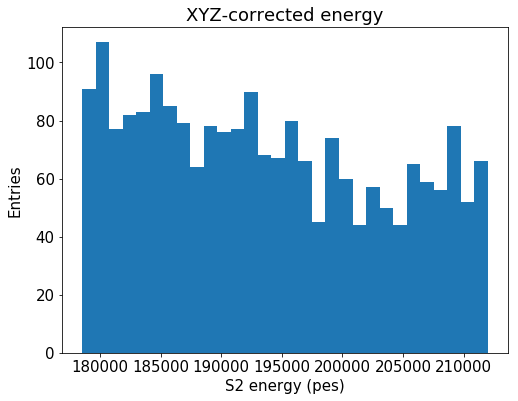

In [299]:
sel               = coref.in_range(E_xyzcorr_1, *cs_range)
background_rate   = np.count_nonzero(sel)      / T_1.max() / 60
u_background_rate = np.count_nonzero(sel)**0.5 / T_1.max() / 60
print("Background rate = {:.5f} +- {:.5f} Hz".format(background_rate, u_background_rate))
hist(E_xyzcorr_1[sel], 30, cs_range)
labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")


Bin size: 20000.0 pes


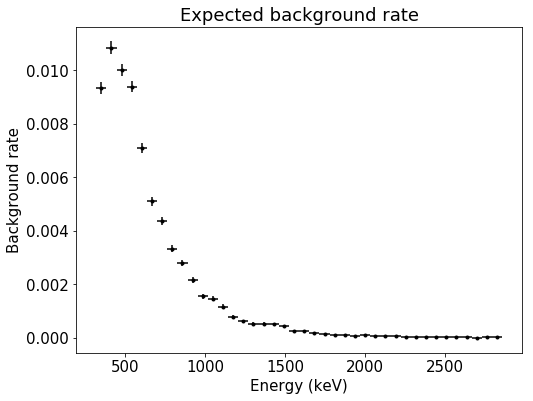

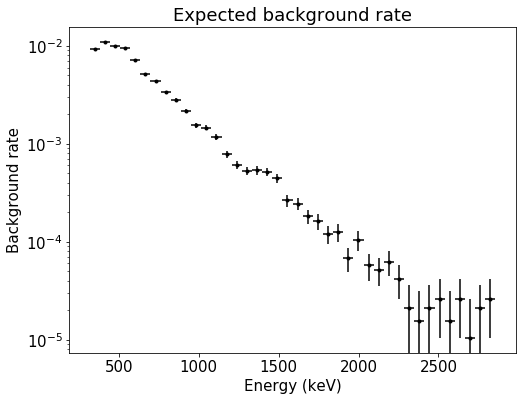

In [304]:
n = 40
Eranges = np.linspace(100e3, 900e3, n+1)
rates   = np.zeros(n)
u_rates = np.zeros(n)
for i in range(n):
    sel               = coref.in_range(E_xyzcorr_1, *Eranges[i:i+2])
    background_rate   =     np.count_nonzero(sel)          / T_1.max() / 60
    u_background_rate = max(np.count_nonzero(sel)**0.5, 3) / T_1.max() / 60
    rates  [i] =   background_rate
    u_rates[i] = u_background_rate

print("Bin size: {} pes".format(np.diff(Eranges)[0]))
energies   = shift_to_bin_centers(Eranges) * 511/161e3
u_energies =   0.5   *    np.diff(Eranges) * 511/161e3 
plt.errorbar(energies, rates,
             u_rates, u_energies,
             "k.")
labels("Energy (keV)", "Background rate", "Expected background rate")

plt.figure()
plt.errorbar(energies, rates,
             u_rates, u_energies,
             "k.")
plt.yscale("log")
labels("Energy (keV)", "Background rate", "Expected background rate")

[  2.32186595e+05   8.85962732e+03   3.07681233e+02   6.28394024e+04
   9.98042972e+03   3.24864667e+02   2.66383489e+01  -1.51770538e-03]
Resolution: 8.161 +- 0.159 % FWHM @ 29.6 keV
Resolution: 0.896 +- 0.017 % FWHM @ 2458 keV


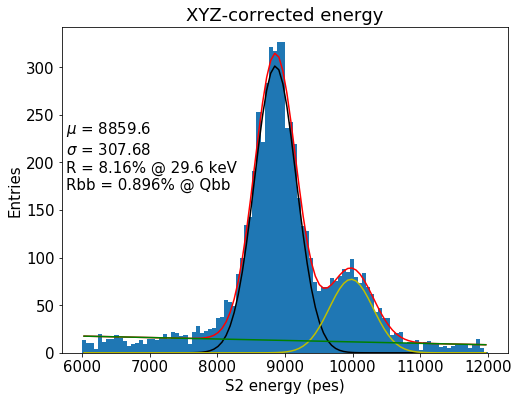

In [137]:
y, x, _ = hist(E_xyzcorr, 100, range=XRrange_corr)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3, 8500, 100, 1e3, 10000, 100,  10, -1e-2
low  =  10, 8000,  50,  10,  9500,  50,   0, -1e-1
upp  = 1e8, 9000, 900, 1e8, 10500, 900, 100, 0
f    = fitf.fit(fun, x, y, seed, fit_range=(6000, 12000), bounds=(low, upp))
print(f.values)
print("Resolution: {:.3f} +- {:.3f} % FWHM @ 29.6 keV".format(*resolution(f.values[:3], f.errors[:3], 29.6)[0]))
print("Resolution: {:.3f} +- {:.3f} % FWHM @ 2458 keV".format(*resolution(f.values[:3], f.errors[:3], 29.6)[1]))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(plt.xlim()[0]*1.01, plt.ylim()[1]/2, gausstext(f.values, 29.6))
labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")

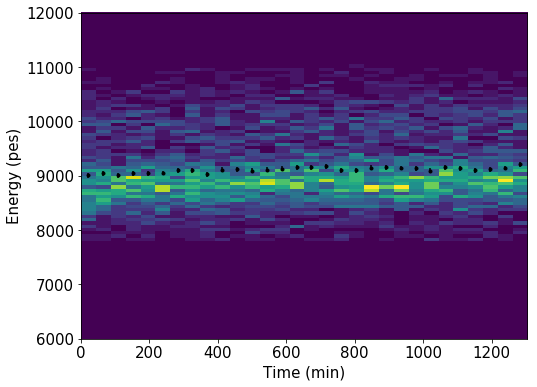

In [144]:
sel     = coref.in_range(E_xyzcorr, 7800, 11000)

T       = full.time.values / 60
T      -= np.min(T)

hist2d(T[sel], E_xyzcorr[sel], (30, 100), ((0, T.max()), XRrange_corr))

x, y, u_y = fitf.profileX(T[sel], E_xyzcorr[sel], 30)
plt.errorbar(x, y, u_y, fmt="k.")

labels("Time (min)", "Energy (pes)")

Tcorr = corrf.Correction((x,), y, u_y, "max")

In [146]:
E_xyztcorr = full.S2e.values * Zcorr(full.Z.values).value *  XYcorr(full.X.values, full.Y.values).value * Tcorr(T).value

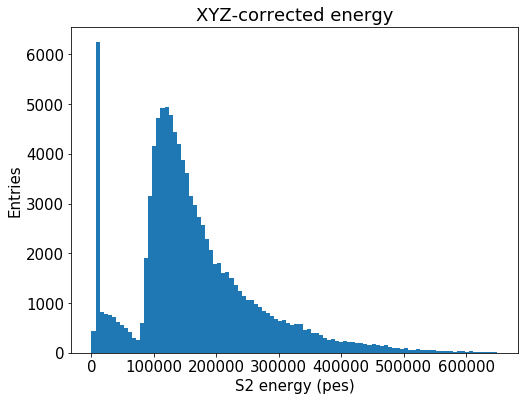

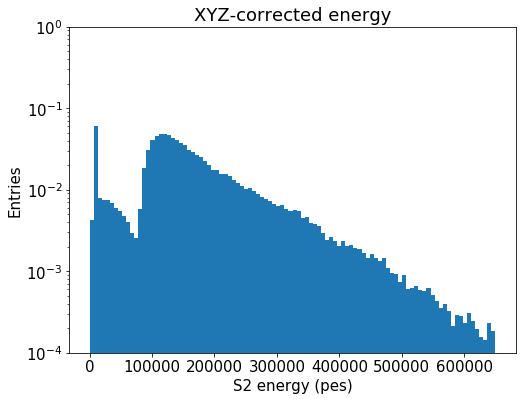

In [147]:
hist(E_xyztcorr, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")

pdf(E_xyztcorr, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")

[  2.31909235e+05   8.96180507e+03   3.09926360e+02   6.29613696e+04
   1.00874836e+04   3.34384272e+02   2.41779597e+01  -1.23478449e-03]
Resolution: 8.127 +- 0.131 % FWHM @ 29.6 keV
Resolution: 0.892 +- 0.014 % FWHM @ 2458 keV


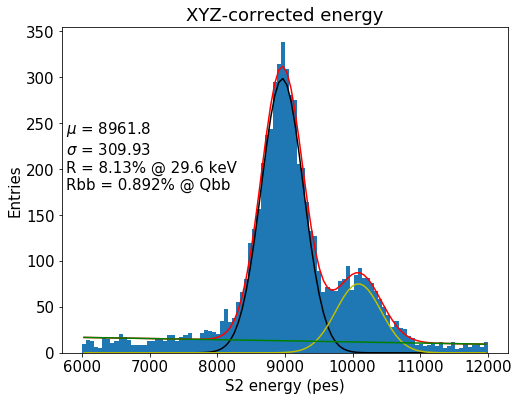

In [148]:
y, x, _ = hist(E_xyztcorr, 100, range=XRrange_corr)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3, 8500, 100, 1e3, 10000, 100,  10, -1e-2
low  =  10, 8000,  50,  10,  9500,  50,   0, -1e-1
upp  = 1e8, 9000, 900, 1e8, 10500, 900, 100, 0
f    = fitf.fit(fun, x, y, seed, fit_range=(6000, 12000), bounds=(low, upp))
print(f.values)
print("Resolution: {:.3f} +- {:.3f} % FWHM @ 29.6 keV".format(*resolution(f.values[:3], f.errors[:3], 29.6)[0]))
print("Resolution: {:.3f} +- {:.3f} % FWHM @ 2458 keV".format(*resolution(f.values[:3], f.errors[:3], 29.6)[1]))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(plt.xlim()[0]*1.01, plt.ylim()[1]/2, gausstext(f.values, 29.6))
labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")

# Tracking

In [ ]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# Kr distribution

In [ ]:
sel     = coref.in_range(E_zcorr, low_cut, high_cut)
Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

In [ ]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

In [ ]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QvsZ")

In [ ]:
x, y, Q, u_Q = \
fitf.profileXY(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, Q)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

x, y, q, u_q = \
fitf.profileXY(Kr.R, Kr.Phi, Kr.S2q, nX, nY, Rrange, Prange)
_, cb = display_matrix(x, y, q)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

In [ ]:
sel = sel_Kr = coref.in_range(Kr.Z.values, *Zrange_XY)

xc, yc, Ec, u_Ec = \
fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nX, nY, XYrange, XYrange)
_, cb = display_matrix(xc, yc, Ec)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EvsXY")

rc, pc, ec, u_ec = \
fitf.profileXY(Kr.R.values[sel], Kr.Phi.values[sel], E_zcorr[sel], nX, nY, Rrange, Prange)
_, cb = display_matrix(xc, yc, ec)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EvsRPhi")

hist2d(Kr.R.values[sel], E_zcorr[sel], (50, 50), range=(Rrange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.R.values[sel], E_zcorr[sel], 50, xrange=Rrange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(Kr.Phi.values[sel], E_zcorr[sel], (50, 50), range=(Prange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.Phi.values[sel], E_zcorr[sel], 50, xrange=Prange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

XYcorr    = corrf.Correction((xc, yc), Ec, u_Ec, "index", index=(nX//2, nY//2))
corr_file = tb.open_file(corr_filename, "w")
kdstio.xy_writer(corr_file)(*XYcorr._xs, XYcorr._fs, XYcorr._us, nXY)
corr_file.close()
print("Reference energy = {} pes".format(Ec[tuple(np.argwhere(XYcorr._fs==1)[0])]))

#### Different pitches

In [ ]:
plt.figure(figsize=(15,12))
for i, (nx, ny) in enumerate(extra_pitches):
    plt.subplot(2, 2, i+1)
    xc_, yc_, Ec_, u_Ec_ = \
    fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nx, ny, XYrange, XYrange)
    _, cb = display_matrix(xc_, yc_, Ec_, new_figure=False)
    cb.set_label("E (pes)")
    pitch = np.diff(np.linspace(*XYrange, nx))[0]
    labels("x (mm)", "y (mm)", "Energy vs XY pitch = {:.1f} mm".format(pitch))
    nXY_ = np.histogram2d(Kr.X.values[sel],
                          Kr.Y.values[sel],
                          (nx, ny),
                          (XYrange, XYrange))[0]
    
    XYcorr_        = corrf.Correction((xc_, yc_), Ec_, u_Ec_, "index", index=(nx//2, ny//2))
    corr_filename_ = corr_filename.replace(".h5", "_{:.1f}mm.h5".format(pitch))
    corr_file_     = tb.open_file(corr_filename_, "w")
    kdstio.xy_writer(corr_file_)(*XYcorr_._xs, XYcorr_._fs, XYcorr_._us, nXY_)
    corr_file_.close()
    print("Reference energy = {} pes".format(Ec_[tuple(np.argwhere(XYcorr_._fs==1)[0])]))
plt.tight_layout()

# Correction maps

In [ ]:
_r = (np.repeat(xc, yc.size)**2 +
      np.tile  (yc, xc.size)**2)**0.5
_f = XYcorr._fs.flatten()
_u = XYcorr._us.flatten()

_, cb = display_matrix(xc, yc, _f)
labels("x (mm)", "y (mm)", "Correction map")
cb.set_label("Correction factor")
save("CorrectionMap")

_, cb = display_matrix(xc, yc, _u)
labels("x (mm)", "y (mm)", "Correction map uncertainty")
cb.set_label("Correction factor uncertainty")
save("CorrectionMapUncertainty")

hist(_f, 100, Frange)
labels("Correction factor", "Entries")
save("CorrectionMapHist")

hist(_u[_u > 0], 100, Urange)
plt.yscale("log")
labels("Correction factor uncertainty", "Entries")
save("CorrectionMapUncertaintyHist")

hist2d(_r, _f, (nR, 100), (Rrange, Frange))
labels("r (mm)", "Correction factor", "Correction factor vs R")
save("CorrectionFactorVsR")

hist2d(_r, _u, (nR, 100), (Rrange, Urange), norm=LogNorm())
labels("r (mm)", "Correction factor uncertainty", "Correction factor uncertainty vs R")
save("CorrectionFactorUncertaintyVsR")

In [ ]:
_x  = np.repeat(xc                      , yc.size - 1)
_y  = np.tile  (shift_to_bin_centers(yc), xc.size    )
_fx = np.diff(XYcorr._fs, axis=1) / (XYcorr._us[:, :-1]**2 + XYcorr._us[:, 1:]**2)**0.5
sel = ~np.isnan(_fx).flatten()

_min = np.nanmean(_fx) - .4*np.nanstd(_fx)
_max = np.nanmean(_fx) + .4*np.nanstd(_fx)

hist(_fx.flatten(), 50,  (_min, _max))
labels("Correction map variation along X", "Entries")

hist2d(_x[sel], _y[sel], (nX, nY), (XYrange, XYrange), weights=_fx.flatten()[sel], vmin=_min, vmax=_max)
labels("x (mm)", "y (mm)", "Correction map variation along X")
plt.colorbar().set_label("Correction factor variation along X")
save("CorrectionMapVariationX")

_x  = np.repeat(shift_to_bin_centers(xc), yc.size    )
_y  = np.tile  (yc                      , xc.size - 1)
_fy = np.diff(XYcorr._fs, axis=0) / (XYcorr._us[:-1, :]**2 + XYcorr._us[1:, :]**2)**0.5
sel = ~np.isnan(_fy).flatten()

_min = np.nanmean(_fy) - .4*np.nanstd(_fy)
_max = np.nanmean(_fy) + .4*np.nanstd(_fy)

hist(_fy.flatten(), 50,  (_min, _max))
labels("Correction map variation along Y", "Entries")
#plt.yscale("log")

hist2d(_x[sel], _y[sel], (nX, nY), (XYrange, XYrange), weights=_fy.flatten()[sel], vmin=_min, vmax=_max)
labels("x (mm)", "y (mm)", "Correction map variation along Y")
plt.colorbar().set_label("Correction factor variation along Y")
save("CorrectionMapVariationX")

# Charge/Energy ratio

In [ ]:
ratio = Q/Ec

hist(ratio.flatten(), 100, QErange)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

_, cb = display_matrix(xc, yc, ratio)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

# Correction by position

In [ ]:
E_xyzcorr = E_zcorr * XYcorr(Kr.X.values, Kr.Y.values).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyzcorr, bins)

fun  = fitf.gauss
ndata = E_xyzcorr.size
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values),  fitOpt)
plt.text(Erange_xycorr[0], 1*max(y)/4, gausstext(f.values, 41.5), color=fitOpt)
labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

In [ ]:
x, y, e, u_e = fitf.profileXY(Kr.X.values, Kr.Y.values, E_xyzcorr, 50, 50, XYrange, XYrange)
_, cb = display_matrix(x, y, e)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "XYZ-corrected energy vs XY")
save("EcorrZXYvsXY")

x, y, e, u_e = fitf.profileXY(Kr.R.values, Kr.Phi.values, E_xyzcorr, 50, 50, Rrange, Prange)
_, cb = display_matrix(x, y, e)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "XYZ-corrected energy vs R$\phi$")
save("EcorrZXYvsRPhi")

hist2d(Kr.R.values, E_xyzcorr, (50, 50), range=(Rrange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.R.values, E_xyzcorr, 50, Rrange, Erange_xycorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)", "XYZ-corrected energy vs R")
save("EcorrZXYvsR")

hist2d(Kr.Phi.values, E_xyzcorr, (50, 50), range=(Prange, Erange_xycorr))
x, y, _ = fitf.profileX(Kr.Phi.values, E_xyzcorr, 50, xrange=Prange, yrange=Erange_xycorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)", "XYZ-corrected energy vs $\phi$")
save("EcorrZXYvsPhi")

# Correction by time

In [ ]:
T      = (Kr.time.values - np.min(Kr.time.values))/60
Trange = 0, np.max(T)

hist2d(T, E_xyzcorr, (50, 50), range=(Trange, Erange_xycorr))

x, y, u_y = fitf.profileX(T, E_xyzcorr, 50, Trange, Erange_xycorr)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZ-corrected energy vs time")
save("EcorrZXYvsT")

Tcorr = corrf.Correction((x,), y, u_y, "max")

In [ ]:
E_xyztcorr = E_xyzcorr * Tcorr(T).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr, bins)

fun  = fitf.gauss
ndata = E_xyztcorr.size
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))
labels("E (pes)", "Entries", "XYZT-corrected energy")
save("EcorrZXYT")

In [ ]:
hist2d(T, E_xyztcorr, (50, 50), range=(Trange, Erange_xycorr))
x, y, _ = fitf.profileX(T, E_xyztcorr, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZT-corrected energy vs time")
save("EcorrZXYTvsT")

# Resolution dependance

In [ ]:
sel_r  = coref.in_range(Kr.R.values, 0, 100)

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_r], bins)

fun   =  fitf.gauss
ndata = np.count_nonzero(sel_r)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial")
save("EcorrZXYT_fiducial")

In [ ]:
sel_z  = coref.in_range(Kr.Z.values, 0, 100)

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_z], bins)

fun   = fitf.gauss
ndata = np.count_nonzero(sel_z)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy short drift")
save("EcorrZXYT_short_drift")

In [ ]:
sel_zr = sel_z & sel_r

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr[sel_zr], bins)

fun   = fitf.gauss
ndata = np.count_nonzero(sel_zr)
seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03

f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
print("Fit values:", f.values)
print("Fit errors:", f.errors)
print("Chi2      :", f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

labels("E (pes)", "Entries", "XYZT-corrected energy fiducial short drift")
save("EcorrZXYT_fiducial_short_drift")

In [ ]:
#Rbins = [0, 40, 60, 80, 100, 115, 130, 140, 150, 160, 170, 180, 190]
Rbins = np.linspace(0, 192, 13)
nbins = len(Rbins) - 1
r     = shift_to_bin_centers(Rbins)
dr    = 0.5 * np.diff       (Rbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 4, i+1)

    sel = coref.in_range(Kr.R.values, *Rbins[i:i+2]) & sel_z

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(E_xyztcorr[sel], bins, new_figure=False)

    fun   = fitf.gauss
    ndata = np.count_nonzero(sel)
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03
    
    f = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp))
    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Rbins[i:i+2]))

    reso = resolution(f.values, f.errors, E_from=41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
plt.tight_layout()
save("EcorrZXYT_Rslices")

In [ ]:
plt.errorbar(r, R, u_R, dr, "kp")
labels("R (mm)", "Resolution", "Resolution vs R")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionvsR")

In [ ]:
Zbins = np.linspace(0, 450, 10)
nbins = len(Zbins) - 1
z     = shift_to_bin_centers(Zbins)
dz    = 0.5 * np.diff       (Zbins)

R, Rbb, u_R, u_Rbb = np.zeros((4, nbins), dtype=np.double)
plt.figure(figsize=(15,12))

for i in range(nbins):
    plt.subplot(3, 3, i+1)
    
    sel = coref.in_range(Kr.Z.values, *Zbins[i:i+2]) & sel_r

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(E_xyztcorr[sel], bins, new_figure=False)

    fun   = fitf.gauss
    ndata = np.count_nonzero(sel)
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03
    
    f = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp))
    plt.plot(x, f.fn(x), fitOpt)
    labels("E (pes)", "Entries", "{:.0f} - {:.0f} mm".format(*Zbins[i:i+2]))

    reso = resolution(f.values, f.errors, E_from=41.5)
    R  [i], u_R  [i] = reso[0]
    Rbb[i], u_Rbb[i] = reso[1]
plt.tight_layout()
save("EcorrZXYT_Zslices")

In [ ]:
plt.errorbar(z, R, u_R, dz, "kp")
labels("Drift time (µs)", "Resolution", "Resolution vs Z")

new_lims  = [lim * (41.5/2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
print("Resolutions", Rbb)
save("ResolutionvsZ")

# Apply map to a orthogonal dataset

In [ ]:
if split_sample:
    test_T     = (test_data.time.values - np.min(full_data.time.values))/60
    correction = Zcorr(test_data.Z.values, test_data.R.values) if LT_radial else\
                 Zcorr(test_data.Z.values)
    Etest_corr = test_data.S2e.values * correction.value\
                                      * XYcorr(test_data.X.values,
                                               test_data.Y.values).value\
                                      * Tcorr(test_T).value

    bins     = np.linspace(*Erange_xycorr, 80)
    bin_size = np.diff(bins)[0]
    y, x, _  = hist(Etest_corr, bins, new_figure=False)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + args[3]
    ndata = Etest_corr.size
    seed  = ndata * bin_size  , Emean_fit, Emean_fit * 0.02, 1e2
    low   = ndata * bin_size/2, Emin_fit , Emin_fit  * 0.01, 0e2
    upp   = ndata * bin_size*2, Emax_fit , Emax_fit  * 0.03, 1e4
    
    f    = fitf.fit(fun, x, y, seed, fit_range=Erange_fit, bounds=(low, upp), sigma=poisson_sigma(y))
    print("Fit values:", f.values)
    print("Fit errors:", f.errors)
    print("Chi2      :", f.chi2)

    plt.plot(x, f.fn(x), fitOpt)
    plt.text(Erange_xycorr[0], max(y)/2, gausstext(f.values, 41.5))

    labels("E (pes)", "Entries", "XYZT-corrected energy")
    save("Etest")